### Make a copy of this note if you want to analyze 

#### Please run panta first to get gene clusters and other output files for this analysis

In [1]:
# # Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install pygraphviz

In [2]:
# Parameters of the algorithm
highlight_genome_seq = [0] # the sequence we want to set very large weights ([] if None)
only_two_weight = False # there are only two weights (highlighted vs non-highlighted genome)

In [3]:
import pandas as pd
from scipy.sparse import csr_matrix
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math

In [4]:
# data_dir = "/home/vanhoan310/server/amromics/panta/examples/test/output/"
data_dir = "data/genome_graph_test/"
# you can take the data in the directory: data/genome_graph_test

In [5]:
sample_info = pd.read_csv(data_dir + "samples.tsv", delimiter='\t', header=None)

In [6]:
sample_info.head()

,0,1
0,GCA_000349285.2_G000_12282012_genomic_sample2,0
1,GCA_022870805.1_ASM2287080v1_genomic_ref1,1


In [7]:
gene_info = pd.read_csv(data_dir + "gene_info.tsv", delimiter='\t', header=None)
gene_info.columns =['GeneName', 'SampleID', 'clusterID']

In [8]:
## select some sample
# selected_samples = [0, 1, 9]
# gene_info = gene_info.loc[gene_info['SampleID'].isin(selected_samples)]
gene_info.head(2)

,GeneName,SampleID,clusterID
0,1_2214-1,1,0
1,0_1812-1,0,0


In [9]:
gene_position = pd.read_csv(data_dir + 'gene_position.tsv', delimiter='\t', header=None)
gene_position.columns =['SampleID', 'ContigName', 'GeneSequence']

In [10]:
# gene_position = gene_position.loc[gene_position['SampleID'].isin(selected_samples)]
gene_position.head(3)

,SampleID,ContigName,GeneSequence
0,0,AOCV01000001.1,0_11;0_2-1;0_3-1;0_4-1;0_5-1;0_61;0_71;0_81;0_...
1,0,AOCV01000002.1,0_243-1;0_244-1;0_245-1;0_2461;0_247-1;0_2481;...
2,0,AOCV01000003.1,0_3301;0_331-1;0_3321;0_3331;0_3341;0_335-1;0_...


In [11]:
# sort by length of contigs
gene_position.sort_values(by="GeneSequence", key=lambda x: x.str.len(),  ascending=False, inplace=True)

In [12]:
gene_position.head(3)

,SampleID,ContigName,GeneSequence
83,1,CP087272.1,1_11;1_21;1_31;1_41;1_51;1_61;1_71;1_81;1_91;1...
26,0,AOCV01000027.1,0_3201-1;0_3202-1;0_3203-1;0_32041;0_32051;0_3...
20,0,AOCV01000021.1,0_19451;0_1946-1;0_19471;0_1948-1;0_1949-1;0_1...


In [13]:
gene_position.loc[gene_position["SampleID"]==18]

,SampleID,ContigName,GeneSequence


In [14]:
print("List of all samples")
n_samples = len(np.unique(gene_position.iloc[:,0]))
np.unique(gene_position.iloc[:,0])

List of all samples


array([0, 1])

# Run here

In [15]:
%load_ext autoreload
%autoreload 2
from pangraph import PanGraph

In [16]:
# construct the pangenome graph
min_contig_len = 100
pangraph = PanGraph(sample_info=sample_info, gene_info=gene_info, gene_position=gene_position)

In [17]:
H = pangraph.construct_graph()

ContigID:  2 , Contig Length:  780 , sample: 0 , # of shared edges:  629 148
ContigID:  3 , Contig Length:  394 , sample: 0 , # of shared edges:  130 260
Set minimum on len of contigs =  100 NUMBER OF COMPUTED CONTIGS: 16


In [18]:
# nx.write_gml(H,'cytoscape_out/pan_graph.gml')

In [19]:
# number of nodes and edges
pangraph.n_clusters, H.number_of_edges()

(10940, 5701)

In [20]:
S = [H.subgraph(c).copy() for c in nx.weakly_connected_components(H)]
# if you want a largest component
# largest_cc = max(nx.weakly_connected_components(G), key=len)

In [21]:
## sort components by size
S.sort(key=lambda x: x.number_of_nodes(), reverse=True)

In [22]:
len(S)

5524

In [23]:
for i in range(len(S)):
    if S[i].number_of_edges() > 5:
        print(i, S[i].number_of_edges(), ",")

0 5429 ,
1 162 ,
2 110 ,


In [24]:
# G = H.subgraph(["C-" + str(i) for i in range (500)])
G = S[0].copy()

In [25]:
G.number_of_nodes(), G.number_of_edges()

(5145, 5429)

In [26]:
nx.write_gml(G,'cytoscape_out/a_pangraph_component.gml')

In [27]:
G_contract = G.copy()

In [28]:
## remove node of in_degree = out_degree = 1 and degree = 0
for node in list(G_contract.nodes()):
    if G_contract.in_degree(node) == 1 and G_contract.out_degree(node) == 1:
        in_edges = list(G_contract.in_edges(node))
        out_edges = list(G_contract.out_edges(node))
        if G_contract[in_edges[0][0]][in_edges[0][1]]['weight'] == G_contract[out_edges[0][0]][out_edges[0][1]]['weight']:
            G_contract.add_edge(in_edges[0][0], out_edges[0][1], weight = G_contract[in_edges[0][0]][in_edges[0][1]]['weight'])
            G_contract.remove_node(node)
    if G_contract.in_degree(node) == 0 and G_contract.out_degree(node) == 0:
        G_contract.remove_node(node)

In [29]:
G_contract.number_of_nodes(), G_contract.number_of_edges()

(318, 597)

In [30]:
nx.write_gml(G_contract,'cytoscape_out/a_simplified_pangraph_component.gml')

In [31]:
G.number_of_nodes(), G.number_of_edges(), G_contract.number_of_nodes(), G_contract.number_of_edges()

(5145, 5429, 318, 597)

In [32]:
# Note that this cluster might not in the final graph because we only select the contig with more than 200 genes.
cluster_id = 2046
# for cluster_id in range(3701, 3710):
df = gene_info.loc[gene_info.iloc[:,2]==cluster_id]
print(df)
print("Gene -> Contig: ", end =" ")
for i in range(len(df.index)):
    print(df.iloc[i,0], "->", pangraph.gene2contigs_dict[df.iloc[i,0]], end =", ")

     GeneName  SampleID  clusterID
4060  0_19791         0       2046
4061  1_23871         1       2046
Gene -> Contig:  0_19791 -> 2, 1_23871 -> 0, 

In [33]:
# import pyttsx3
# engine = pyttsx3.init()
# engine.say(G.number_of_nodes())
# engine.say("The reduced graph has ")
# engine.say(G_contract.number_of_nodes())
# engine.say(G_contract.number_of_nodes())
# engine.say("Number of genomes: ")
# engine.say(n_samples)
# engine.say(n_samples)
# engine.runAndWait()

In [34]:
gene_contigs = gene_position.iloc[0,2].split(";")

In [38]:
contig_graph = pangraph.join_contig(sample_id=0)

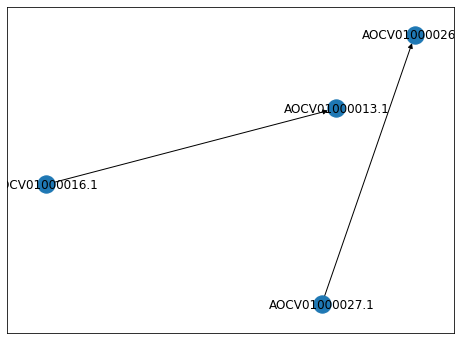

In [39]:
plt.figure(3,figsize=(8,6)) 
nx.draw_networkx(contig_graph, pos=nx.random_layout(contig_graph), with_labels=True)
plt.show()

In [40]:
nx.write_gml(contig_graph,'cytoscape_out/contig_graph.gml')